DEBUG:cmdstanpy:input tempfile: /tmp/tmp59saivkc/aeg5epq6.json


DEBUG:cmdstanpy:input tempfile: /tmp/tmp59saivkc/yusow3pk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/workspaces/Forecasts/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15100', 'data', 'file=/tmp/tmp59saivkc/aeg5epq6.json', 'init=/tmp/tmp59saivkc/yusow3pk.json', 'output', 'file=/tmp/tmp59saivkc/prophet_model4azbv9vf/prophet_model-20250319054844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:48:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:48:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


El modelo Prophet se ajustó correctamente.
        Fechas      Llamadas
0   2020-03-03  21034.919374
1   2020-03-04  20968.698373
2   2020-03-05  20656.355856
3   2020-03-06  20548.673488
4   2020-03-07  17197.800267
..         ...           ...
547 2021-09-01  19402.471389
548 2021-09-02  18953.691778
549 2021-09-03  19124.699309
550 2021-09-04  16197.798180
551 2021-09-05  11554.547875

[552 rows x 2 columns]
El pronóstico se guardó en: /workspaces/Forecasts/predicciones.csv


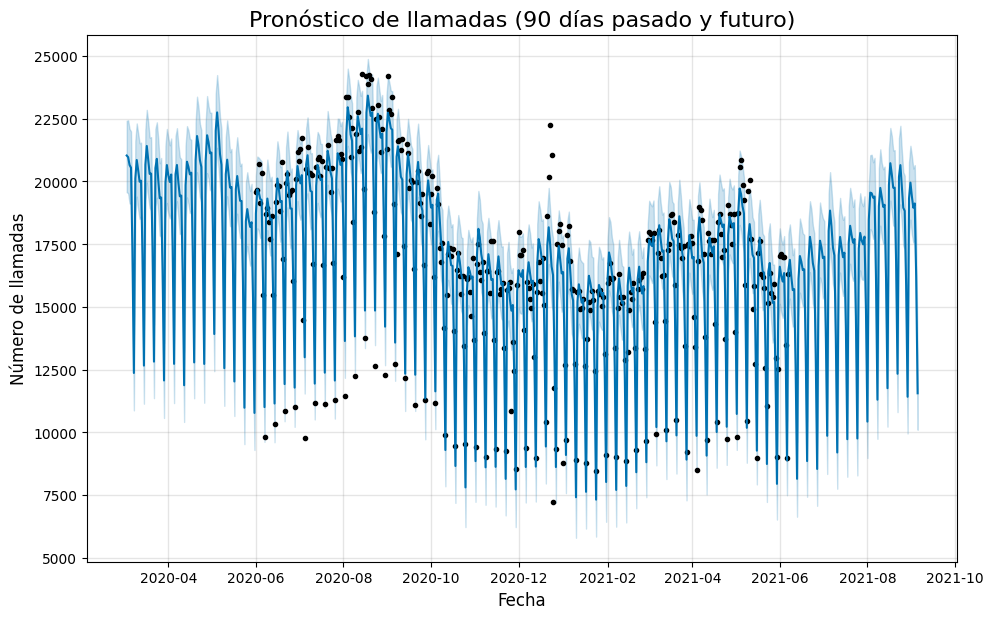

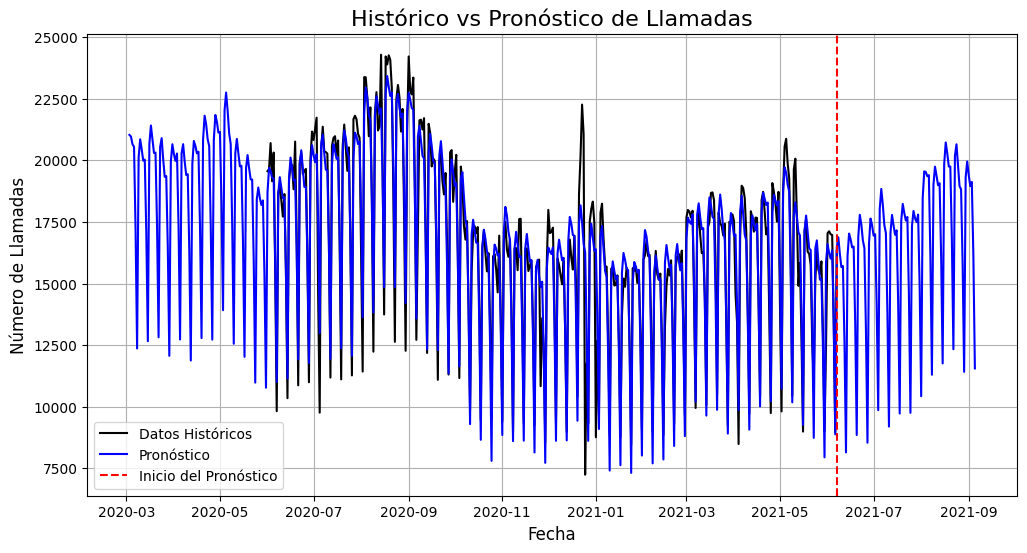

Error Absoluto Medio (MAE) del modelo: 764.43
El modelo se guardó correctamente en: /workspaces/Forecasts/models/prophet_daily_model.pkl


In [28]:
import os
import pickle
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import mean_absolute_error

# Configurar el logger
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

# Cargar el dataset
try:
    # Cargar el archivo CSV desde la ruta especificada
    df = pd.read_csv('../history/DAILY.csv')
    
    # Convertir la columna 'Fechas' al formato datetime
    df['Fechas'] = pd.to_datetime(df['Fechas'], format='%d/%m/%Y', errors='coerce')
    
    # Verificar si hay fechas inválidas
    if df['Fechas'].isna().any():
        print("Fechas inválidas detectadas, verifica el archivo CSV:")
        print(df[df['Fechas'].isna()])
        exit()
    
    # Renombrar las columnas según el formato requerido por Prophet
    df.rename(columns={'Fechas': 'ds', 'Llamadas': 'y'}, inplace=True)
except FileNotFoundError:
    print("El archivo DAILY.csv no fue encontrado en la ruta especificada.")
    exit()
except Exception as e:
    print(f"Error al cargar el archivo: {e}")
    exit()

# Crear y ajustar el modelo Prophet con estacionalidades diaria, semanal, mensual y anual
try:
    model = Prophet(
        daily_seasonality=True,   # Estacionalidad diaria
        weekly_seasonality=True, # Estacionalidad semanal
        yearly_seasonality=True  # Estacionalidad anual
    )
    # Añadir la estacionalidad mensual manualmente
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    model.fit(df)
    print("El modelo Prophet se ajustó correctamente.")
except ValueError as e:
    print(f"Error en los datos durante el ajuste del modelo: {e}")
    exit()
except Exception as e:
    print(f"Se produjo un error inesperado al ajustar el modelo: {e}")
    exit()

# Crear DataFrames para las fechas futuras (90 días futuros) y pasadas (90 días conocidos)
future = model.make_future_dataframe(periods=90, freq='D')
past = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min() - pd.DateOffset(days=90), 
                                         end=df['ds'].min() - pd.DateOffset(days=1), freq='D')})
combined = pd.concat([past, future], ignore_index=True)

# Realizar la predicción
forecast = model.predict(combined)

# Mostrar el pronóstico en formato DataFrame con columnas "Fechas" y "Llamadas"
forecast_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'Fechas', 'yhat': 'Llamadas'})

# Imprimir el DataFrame resultante
print(forecast_df)

# Exportar las predicciones a un archivo CSV
output_csv = '/workspaces/Forecasts/predicciones.csv'
forecast_df.to_csv(output_csv, index=False)
print(f"El pronóstico se guardó en: {output_csv}")

# Graficar los resultados con Prophet
fig1 = model.plot(forecast)

# Personalizar el gráfico con etiquetas y título
plt.title('Pronóstico de llamadas (90 días pasado y futuro)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de llamadas', fontsize=12)
plt.grid(True)
plt.show()

# Crear un gráfico lineal combinado para el histórico y el pronóstico
plt.figure(figsize=(12, 6))

# Plot del histórico (datos reales)
plt.plot(df['ds'], df['y'], label='Datos Históricos', color='black')

# Plot del pronóstico (predicciones)
plt.plot(forecast['ds'], forecast['yhat'], label='Pronóstico', color='blue')

# Personalizar el gráfico
plt.title('Histórico vs Pronóstico de Llamadas', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Llamadas', fontsize=12)
plt.axvline(x=df['ds'].max(), color='red', linestyle='--', label='Inicio del Pronóstico')  # Línea para separar histórico del pronóstico
plt.legend()
plt.grid(True)
plt.show()


# Evaluar la efectividad del modelo (usando datos históricos)
try:
    known_data = forecast[forecast['ds'].isin(df['ds'])]  # Filtrar las fechas que ya conocemos
    mae = mean_absolute_error(df['y'], known_data['yhat'])  # Comparar valores reales y predichos
    print(f"Error Absoluto Medio (MAE) del modelo: {mae:.2f}")
except Exception as e:
    print(f"No se pudo calcular la evaluación del modelo: {e}")


# Crear un diccionario con los detalles del modelo Prophet
model_dict = {
    'model': model,
    'algorithm_name': 'Prophet',
    'author': 'Enrique',
    'dataset_info': {
        'num_records': len(df),
        'columns': list(df.columns)
    },
    'prediction_info': {
        'forecast_horizon_future': 90,  # Días futuros
        'past_window': 90               # Días conocidos
    },
    'notes': 'Modelo diario de llamadas con estacionalidades diaria, semanal, mensual y anual'
}

# Crear la ruta del archivo para guardar el modelo
output_dir = '/workspaces/Forecasts/models'
output_file = 'prophet_daily_model.pkl'

# Guardar el modelo en un archivo pickle
try:
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, output_file), 'wb') as file:
        pickle.dump(model_dict, file)
        print("El modelo se guardó correctamente en:", os.path.join(output_dir, output_file))
except Exception as e:
    logger.error(f"Ha ocurrido un error al guardar el modelo: {e}")
